<a href="https://colab.research.google.com/github/amirhnazerii/DS_prep/blob/main/Adv_Detection_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create Clean Logits Dataset:

```
current file: Adv_Detection_v1.ipynb
previous version: Adv_Detection_v0.ipynb
latest update:
- fixed FileNotFound bug in DataLoader by creating `CustomCocoDetection` class.
- saved clean logits of coco 2017val dataset.

```

In [5]:
import sys
import os

# Path to the directory containing your custom module
module_dir = '/content/content/MyDrive/Research/Adversarial Detection'

# Add the directory to the Python path
sys.path.insert(0, module_dir)


In [6]:
import torch
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, Dataset
from transformers import DetrForObjectDetection, DetrImageProcessor
import numpy as np
from scipy.spatial.distance import mahalanobis
from collections import defaultdict

## custom module borrowed from Detr Repo: util.misc
import misc as utils

import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T

In [7]:
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [8]:
class Visuals():

    # COCO classes
    CLASSES = [
        'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
        'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
        'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
        'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
        'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
        'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
        'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
        'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
        'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
        'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
        'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
        'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
        'toothbrush'
    ]

    # colors for visualization
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
              [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

    # for output bounding box post-processing
    def box_cxcywh_to_xyxy(x):
        x_c, y_c, w, h = x.unbind(1)
        b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
            (x_c + 0.5 * w), (y_c + 0.5 * h)]
        return torch.stack(b, dim=1)

    def rescale_bboxes(out_bbox, size):
        img_w, img_h = size
        b = Visuals.box_cxcywh_to_xyxy(out_bbox)
        b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
        return b

    def plot_results(pil_img, prob, boxes):
        plt.figure(figsize=(16,10))
        plt.imshow(pil_img)
        ax = plt.gca()
        colors = Visuals.COLORS * 100
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                      fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{Visuals.CLASSES[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
        plt.axis('off')
        plt.show()

    def plotter_flex(list_of_tensors):
        '''
        input: list of tensors
        '''
        plt.figure(figsize=(20, 6))
        for tensor in list_of_tensors:
            plt.plot(tensor.cpu().detach().numpy())


In [9]:
def prediction_visualization(self):
    # Call prediction once and store the results
    result = self.prediction()
    bboxes_scaled = Visuals.rescale_bboxes(result['outputs']['pred_boxes'][0, result['keep']], self.get_img().size)
    Visuals.plot_results(self.get_img(), result['probas'][result['keep']], bboxes_scaled)

In [10]:
class CustomCocoDetection(torchvision.datasets.CocoDetection):
      def __init__(self, root, annFile: str, transform, target_transform = None, transforms = None):
          super().__init__(root, annFile, transform, target_transform, transforms)

      def url_generator(self, img_id: int):
          return f'http://images.cocodataset.org/val2017/{(12-len(str(img_id)))*"0"+str(img_id)}.jpg'

      def _load_image(self, id: int) -> Image.Image:
          return Image.open(requests.get(self.url_generator(id), stream=True).raw).convert("RGB") # im


In [11]:
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Custom collate function to handle variable-sized annotations
def custom_collate_fn(batch):
    batch = list(zip(*batch))  # Unpack the images and targets
    return batch

# Updated DataLoader function
def load_detr_and_coco(batch_size=1, dataset_dir="", annotation_file=""):
    # Load pre-trained DETR model
    detr = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
    detr.eval()
    detr.to('cuda')

    # Preprocessing pipeline
    processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

    # COCO val-2017 dataset
    dataset = CustomCocoDetection(
        root= None,  #dataset_dir,  # Provide your image path here
        annFile=annotation_file,  # Provide your annotation path here
        transform = T.Compose([
        T.Resize(800),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])
    )

#     T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    sampler_val = torch.utils.data.SequentialSampler(dataset)
# data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
#                              drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)


    dataloader = DataLoader(
        dataset,
        batch_size = 1,
        sampler= sampler_val,
        num_workers=2,
        shuffle=False,
        collate_fn= custom_collate_fn #utils.collate_fn  # Use the custom collate function
    )
    return dataset, detr, processor, dataloader


In [12]:
from tqdm import tqdm

In [13]:
# --- Step 2: Extract Filtered Logits ---
def extract_filtered_logits(detr, processor, dataloader, confidence_threshold, troubleshooting = False):
    class_logits = defaultdict(list)  # Store logits grouped by class
    count = 0

    for i, (images, annot) in tqdm(enumerate(dataloader)):

        # if i > 800:
            # Preprocess images for DETR
            # inputs = processor(images, return_tensors="pt", padding=True)

            try:
                with torch.no_grad():
                    images= images[0].unsqueeze(0).to('cuda')
                    outputs = detr(images)


                # Extract logits and calculate probabilities
                logits = outputs.logits.cpu().numpy()  # Shape: (batch_size, num_queries, num_classes)
                probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()  # Class probabilities
                confidences = np.max(probs[:, :, :-1], axis=-1)  # Exclude "no-object" class
                # print(len(confidences), len(confidences[0]))
                # print(confidences)
                # Filter logits with high confidence
                for batch_logits, batch_confidences in zip(logits, confidences):
                    for query_logits, query_conf in zip(batch_logits, batch_confidences):
                        if query_conf > confidence_threshold:
                            predicted_class = np.argmax(query_logits[:-1])  # Exclude "no-object" class
                            class_logits[predicted_class].append(query_logits[:-1])  # Store per class
                            count += 1
                            # print(count)
                            # print(class_logits)
                            # print(annot)
                # break
                # return class_logits, annot
            except FileNotFoundError as e:
                  print(f"File missing at batch {i}: {e}. Skipping...")
                  continue  # Move to the next image

    # Convert lists to numpy arrays
    for cls in class_logits:
        class_logits[cls] = np.array(class_logits[cls])

    return class_logits, annot

In [14]:
### --- Main Script ---
if __name__ == "__main__":
    # Load DETR and COCO dataset
    dataset, detr, processor, dataloader = load_detr_and_coco(dataset_dir="/content/content/MyDrive/Research/Adversarial Detection/CocoDrive/val2017",
                                                 annotation_file="/content/content/MyDrive/Research/Adversarial Detection/CocoDrive/annotations/instances_val2017.json")

    # # Step 1: Extract filtered logits
    # clean_logits = extract_filtered_logits(detr, processor, dataloader, confidence_threshold=0.7)

    # # Step 2: Compute class-specific Mahalanobis parameters
    # class_params = compute_class_mahalanobis_params(clean_logits)

    # # Step 3: Detect adversarial examples
    # results = detect_adversarial_samples(detr, processor, dataloader, class_params, distance_threshold=5.0)

    # # Print sample results
    # for result in results[:10]:  # Display first 10 results
    #     print(result)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

loading annotations into memory...
Done (t=1.96s)
creating index...
index created!


In [15]:
# Step 1: Extract filtered logits
clean_logits, annot = extract_filtered_logits(detr, processor, dataloader, confidence_threshold=0.9, troubleshooting= True)

5000it [10:22,  8.03it/s]


In [18]:
import pickle

# Save to file
with open("/content/content/MyDrive/Research/Adversarial Detection/CocoDrive/"+"clean_logits.pkl", "wb") as f:
    pickle.dump(clean_logits, f)

# # Load from file
# with open("clean_logits.pkl", "rb") as f:
#     loaded_logits = pickle.load(f)


'dining table'

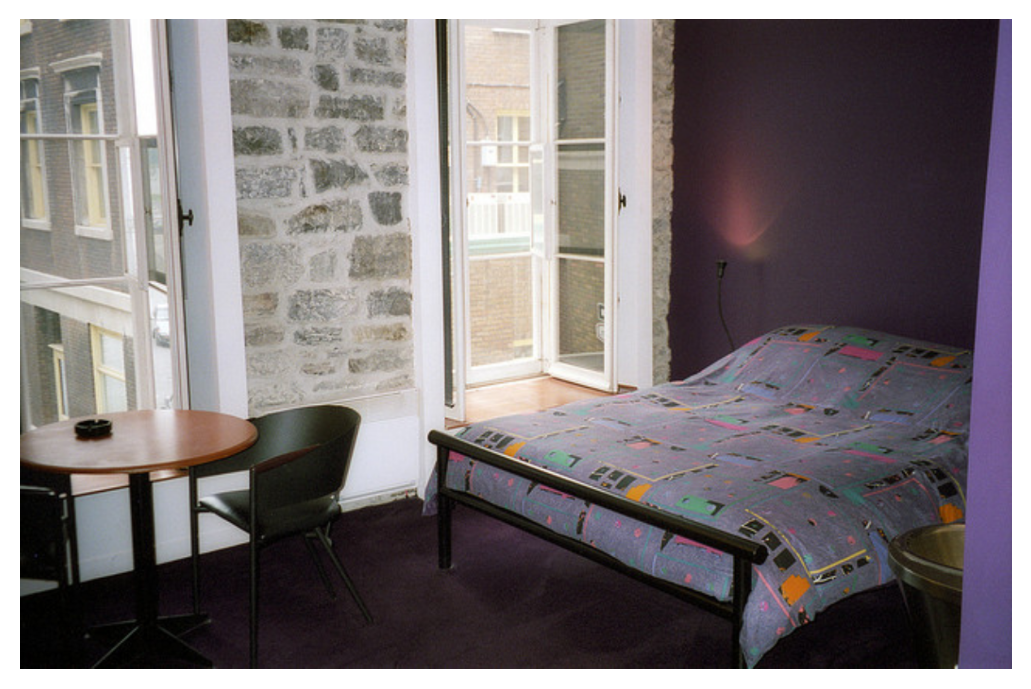

In [17]:
for i, (img, ann) in enumerate(dataloader):

    if i == 21:
        img = img[0]
        break


# import torch
# import matplotlib.pyplot as plt
# import numpy as np

# Assuming images is the tensor of size 1x3x800 (batch_size=1, 3 channels, 800x800 image)
# Let's first remove the batch dimension (images.shape is (1, 3, 800)) and get the image tensor
image = img  # Now shape is (3, 800, 800)

# Reverse normalization (if necessary)
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# Denormalize (reverse the normalization)
image = image * std[:, None, None] + mean[:, None, None]

# Convert to numpy (H, W, C format)
image = image.permute(1, 2, 0).cpu().numpy()

# Clip values to [0, 1] range, as image values should be in that range for plt.imshow
image = np.clip(image, 0, 1)

# Show the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Optional: to turn off the axis
plt.show()


In [ ]:
clean_logits[62][1]

array([-12.4675255 ,   0.9165826 ,  -1.9297782 ,  -1.172711  ,
        -1.1177524 ,  -4.699008  ,  -9.710932  , -12.288437  ,
        -5.0894547 ,  -4.3611736 , -10.178661  ,  -8.776235  ,
       -12.448947  ,  -9.06483   ,  -2.7051332 ,   0.7487676 ,
        -4.718561  ,  -4.1460752 ,  -4.0978785 ,  -4.306381  ,
        -2.575117  ,  -6.011618  ,  -5.265633  , -11.833414  ,
        -2.813181  , -12.526844  , -12.36625   ,  -3.2484655 ,
        -2.437057  , -12.331296  , -12.001977  ,  -3.82168   ,
        -5.41263   ,  -4.5796456 ,  -7.472887  ,  -5.994583  ,
        -8.55156   ,  -0.6929789 ,  -6.620706  ,  -2.6735241 ,
        -2.424568  ,  -7.405623  ,  -2.4550548 ,  -1.8388839 ,
        -4.764939  , -12.121253  ,  -3.4728706 ,  -0.8771273 ,
        -2.7505164 ,  -6.046636  ,  -4.188458  ,  -2.1935203 ,
        -5.7520285 ,  -7.6563044 ,  -5.8622794 ,  -7.462065  ,
        -5.8014    , -15.651138  , -11.008796  ,  -7.503816  ,
        -5.114075  ,  -7.5234184 ,  11.626016  ,  -0.46

In [19]:
import pickle

# # Load from file
with open("/content/content/MyDrive/Research/Adversarial Detection/CocoDrive/"+"clean_logits.pkl", "rb") as f:
    loaded_logits = pickle.load(f)

In [23]:
loaded_logits.keys()

dict_keys([86, 62, 78, 64, 72, 67, 44, 82, 85, 1, 23, 65, 84, 13, 88, 35, 79, 37, 43, 27, 9, 31, 16, 77, 51, 54, 42, 74, 73, 76, 3, 8, 2, 6, 17, 5, 24, 10, 32, 53, 39, 57, 49, 46, 61, 40, 50, 47, 52, 70, 56, 41, 48, 75, 63, 20, 7, 81, 22, 34, 28, 19, 18, 4, 38, 59, 11, 33, 15, 21, 25, 58, 87, 36, 14, 60, 55, 89, 80, 90])

In [30]:
loaded_logits[1].shape

(9401, 91)